In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
ROOT_DIR = '/content/'
df_org= pd.read_csv(ROOT_DIR + "Aymane.csv")
df_org = df_org.sample(frac=1.0, random_state=42)
df_org.head()

,category,text
9,<heeftHistorischeBetekenis>,Description of the historical or architectural...
25,<Locatie>,Root tag for a location entity.
8,<beschermdDoor>,Links the monument to the legal decree protect...
21,<beschermt>,Links the decree to the monument it protects.
0,<Monument>,Root tag for a monument entity.


In [4]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['<heeftHistorischeBetekenis>',
 '<Locatie>',
 '<beschermdDoor>',
 '<beschermt>',
 '<Monument>',
 '<geassocieerdMet>',
 '<tijdperk>',
 '<wettelijkeBasis>',
 '<heeftNaam>',
 '<volgtArchitectuurstijl>',
 '<Architectuurstijl>',
 '<heeftKadastraleInformatie>',
 '<ontworpenDoor>',
 '<heeftAdres>',
 '<typeBescherming>,"The type of protection (""voorlopig"" or ""definitief"")."',
 '<gevestigdIn>,"Links the monument to its location (city, "',
 '<gerelateerdMonument>',
 '<toegepastOp>',
 '<bevatMonument>',
 '<heeftBesluitDatum>',
 '<heeftBouwdatum>',
 '<Architect>',
 '<heeftGeboortejaar>',
 '<Besluit>']


## Why we need id2label and labe2ids in NLP Projects

In NLP tasks, especially those involving classification problems, id2label and label2id dictionaries are used to map class labels (categories) to integer IDs and vice versa. These mappings are essential for various stages of the NLP pipeline, such as data preprocessing, model training, and evaluation.

Data preprocessing: In order to feed text data into an NLP model, the text must first be tokenized and then converted into numerical values. Similarly, class labels must also be transformed into numerical representations. The label2id dictionary helps in converting the original class labels into integer IDs.

Model training: NLP models usually output probability distributions over classes as their predictions. During training, the model's predictions are compared against the ground truth labels (which have been converted to integer IDs) to compute the loss and optimize the model parameters.

Model evaluation and interpretation: Once the model has been trained, its predictions (in the form of integer IDs) need to be mapped back to their original class labels to make the results interpretable. The id2label dictionary is used to perform this conversion.


For `BertForSequenceClassification` model as well I need these exact mapping of id2labels and labels2id in dictionary form.

### Hence, fefore you start training your model, create a map of the expected ids to their labels with id2label and label2id:

In [5]:
for key, value in enumerate(labels):
    print(value)

<heeftHistorischeBetekenis>
<Locatie>
<beschermdDoor>
<beschermt>
<Monument>
<geassocieerdMet>
<tijdperk>
<wettelijkeBasis>
<heeftNaam>
<volgtArchitectuurstijl>
<Architectuurstijl>
<heeftKadastraleInformatie>
<ontworpenDoor>
<heeftAdres>
<typeBescherming>,"The type of protection (""voorlopig"" or ""definitief"")."
<gevestigdIn>,"Links the monument to its location (city, "
<gerelateerdMonument>
<toegepastOp>
<bevatMonument>
<heeftBesluitDatum>
<heeftBouwdatum>
<Architect>
<heeftGeboortejaar>
<Besluit>


In [6]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [7]:
label2id

{'<heeftHistorischeBetekenis>': 0,
 '<Locatie>': 1,
 '<beschermdDoor>': 2,
 '<beschermt>': 3,
 '<Monument>': 4,
 '<geassocieerdMet>': 5,
 '<tijdperk>': 6,
 '<wettelijkeBasis>': 7,
 '<heeftNaam>': 8,
 '<volgtArchitectuurstijl>': 9,
 '<Architectuurstijl>': 10,
 '<heeftKadastraleInformatie>': 11,
 '<ontworpenDoor>': 12,
 '<heeftAdres>': 13,
 '<typeBescherming>,"The type of protection (""voorlopig"" or ""definitief"")."': 14,
 '<gevestigdIn>,"Links the monument to its location (city, "': 15,
 '<gerelateerdMonument>': 16,
 '<toegepastOp>': 17,
 '<bevatMonument>': 18,
 '<heeftBesluitDatum>': 19,
 '<heeftBouwdatum>': 20,
 '<Architect>': 21,
 '<heeftGeboortejaar>': 22,
 '<Besluit>': 23}

In [8]:
id2label

{0: '<heeftHistorischeBetekenis>',
 1: '<Locatie>',
 2: '<beschermdDoor>',
 3: '<beschermt>',
 4: '<Monument>',
 5: '<geassocieerdMet>',
 6: '<tijdperk>',
 7: '<wettelijkeBasis>',
 8: '<heeftNaam>',
 9: '<volgtArchitectuurstijl>',
 10: '<Architectuurstijl>',
 11: '<heeftKadastraleInformatie>',
 12: '<ontworpenDoor>',
 13: '<heeftAdres>',
 14: '<typeBescherming>,"The type of protection (""voorlopig"" or ""definitief"")."',
 15: '<gevestigdIn>,"Links the monument to its location (city, "',
 16: '<gerelateerdMonument>',
 17: '<toegepastOp>',
 18: '<bevatMonument>',
 19: '<heeftBesluitDatum>',
 20: '<heeftBouwdatum>',
 21: '<Architect>',
 22: '<heeftGeboortejaar>',
 23: '<Besluit>'}

In [9]:
df_org.head()

,category,text
9,<heeftHistorischeBetekenis>,Description of the historical or architectural...
25,<Locatie>,Root tag for a location entity.
8,<beschermdDoor>,Links the monument to the legal decree protect...
21,<beschermt>,Links the decree to the monument it protects.
0,<Monument>,Root tag for a monument entity.


### Create a new column to represent the categories in numerical form

I need a 'label' column heading with numeric value else while running the epochs with `trainer.train()` I will get below error

```
BertForSequenceClassification ValueError: The model did not return

```


### In below I am doing it manually, but I could have also done it with pd.factorize() as below

Pandas factorize method is used for encoding categorical variables as integers. It assigns a unique integer value to each distinct category in a given Series or DataFrame, effectively transforming non-numeric data into numeric values.

In [10]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [11]:
df_org.head()

,category,text,labels
9,<heeftHistorischeBetekenis>,Description of the historical or architectural...,0
25,<Locatie>,Root tag for a location entity.,1
8,<beschermdDoor>,Links the monument to the legal decree protect...,2
21,<beschermt>,Links the decree to the monument it protects.,3
0,<Monument>,Root tag for a monument entity.,4


<Axes: ylabel='count'>

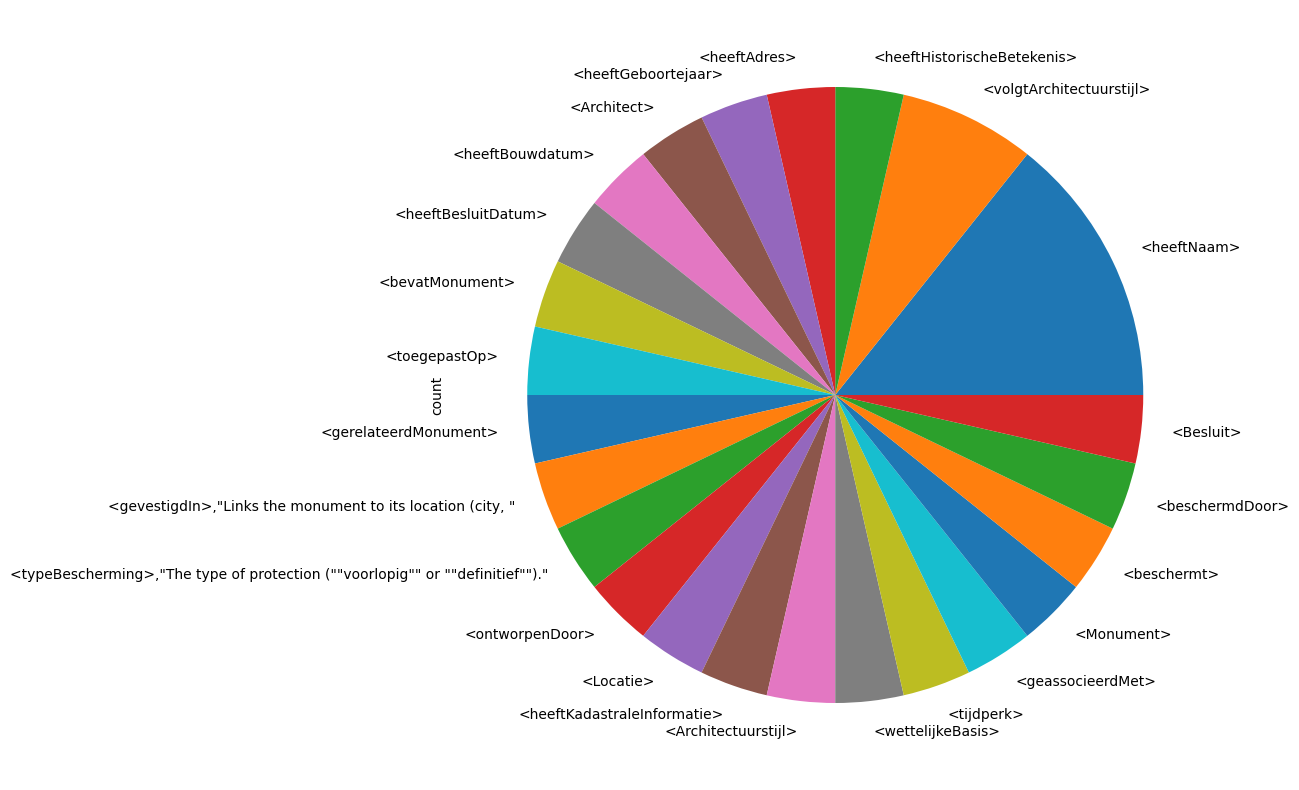

In [12]:
df_org.category.value_counts().plot(kind='pie', figsize=(10,10))

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("GroNLP/bert-base-dutch-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
from transformers import AutoModelForSequenceClassification
model = BertForSequenceClassification.from_pretrained("GroNLP/bert-base-dutch-cased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30073, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Splitting df_org


In [15]:
SIZE= df_org.shape[0]

train_texts= list(df_org.text[:SIZE//2])

val_texts=   list(df_org.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [16]:
len(train_texts)


14

In [17]:
len(train_texts), len(val_texts), len(test_texts)

(14, 7, 7)

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(test_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [19]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [20]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training with Trainer Class

In [21]:
from transformers import TrainingArguments, Trainer

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


## compute_metrics

argmax(): The NumPy method argmax() returns the index of the maximum value along a given axis. In a classification problem, we are interested in finding the class with the highest probability for each observation.

(-1): The (-1) inside argmax() represents the axis along which the operation should be performed. In Python, negative indices are used to access elements from the end. So, (-1) here means the last axis, which is the columns in a 2D array.

In [23]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=150,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [25]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,2.163600,3.561309,0.142857,0.060606,0.090909,0.045455
100,0.160600,5.045983,0.142857,0.060606,0.090909,0.045455
150,0.012700,5.296958,0.142857,0.060606,0.090909,0.045455


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

TrainOutput(global_step=150, training_loss=0.7789769506454468, metrics={'train_runtime': 426.7952, 'train_samples_per_second': 4.92, 'train_steps_per_second': 0.351, 'total_flos': 23746351305600.0, 'train_loss': 0.7789769506454468, 'epoch': 150.0})

In [34]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.006719,1.000000,1.000000,1.000000,1.000000
val,5.296958,0.142857,0.060606,0.090909,0.045455
test,5.676163,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.006719,1.000000,1.000000,1.000000,1.000000
val,5.296958,0.142857,0.060606,0.090909,0.045455
test,5.676163,0.000000,0.000000,0.000000,0.000000


In [35]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [36]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


## Save model for inference

In [37]:
model_path = "abb-dutch-text-classification-model-v1"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('abb-dutch-text-classification-model-v1/tokenizer_config.json',
 'abb-dutch-text-classification-model-v1/special_tokens_map.json',
 'abb-dutch-text-classification-model-v1/vocab.txt',
 'abb-dutch-text-classification-model-v1/added_tokens.json',
 'abb-dutch-text-classification-model-v1/tokenizer.json')

('abb-dutch-text-classification-model-v1/tokenizer_config.json',
 'abb-dutch-text-classification-model-v1/special_tokens_map.json',
 'abb-dutch-text-classification-model-v1/vocab.txt',
 'abb-dutch-text-classification-model-v1/added_tokens.json',
 'abb-dutch-text-classification-model-v1/tokenizer.json')

## Re-Load saved model for inference

In [38]:
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("text-classification", model=model, tokenizer=tokenizer)

In [39]:
nlp("Links the architectural style to the monument it is applied to.")

[{'label': '<volgtArchitectuurstijl>', 'score': 0.4417971670627594}]

[{'label': '<volgtArchitectuurstijl>', 'score': 0.4417971670627594}]

In [40]:
nlp("Date of the legal decree.")

[{'label': '<heeftNaam>', 'score': 0.5996589660644531}]

[{'label': '<heeftNaam>', 'score': 0.5996589660644531}]

In [41]:
nlp("Root tag for a location entity.")

[{'label': '<Locatie>', 'score': 0.9928842782974243}]

[{'label': '<Locatie>', 'score': 0.9928842782974243}]